In [144]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint


# Exercise 1

## Setup data 

In [145]:
# CONTROL VARIABLES
batteryOn = False


# DATA
countries = ['DE', 'DK', 'SE']
techs = ['Wind', 'PV', 'Gas', 'Hydro', 'Battery']
efficiency = {'Wind': 1, 'PV': 1, 'Gas': 0.4, 'Hydro': 1, 'Battery': 0.9}
discountrate = 0.05
hydro_max =33 * 10**6
CO2_gas_emission_factor = 0.202

# READ CSV
input_data = pd.read_csv('data/TimeSeries.csv', index_col=[0])
cap_max_data = pd.read_csv('data/capMax.csv', index_col=[0])  # MWh
cost_data = pd.read_csv('data/costs.csv', index_col=[0])

print(f"Total demand DK: {input_data['Load_DK'].sum()/1000}")
print(f"Total demand DE: {input_data['Load_DE'].sum()/1000}")
print(f"Total demand SE: {input_data['Load_SE'].sum()/1000}")


Total demand DK: 43606.417933
Total demand DE: 637617.0658
Total demand SE: 177332.34219999998


## Utility functions

In [146]:
# UTILITY FUNCTIONS
def annualize_cost(tech):
    lifetime = cost_data.loc[tech]["lifetime"]
    return discountrate/(1-1/(1+discountrate)**lifetime)


def investment_cost(model):
    return sum( model.capa[node, tech] * cost_data.loc[tech]["investment_cost"]  * annualize_cost(tech) for tech in model.gens for node in model.nodes)

def running_cost(model):
    return sum(model.prod[node, tech, t] * (cost_data.loc[tech]["variable_cost"] + cost_data.loc[tech]["fuel_cost"]) for node in model.nodes for tech in model.gens for t in model.time)


def capacity_max(model, n, g):
    capMax = {}
    if g in cap_max_data.columns:
        capMax[n, g] = float(cap_max_data[g].loc[cap_max_data.index == n])
        return 0.0, capMax[n, g]
    elif g == 'Battery' and not batteryOn:
        return 0.0, 0.0
    else:
        return 0.0, None


def demandData():
    demand = {}
    for n in model.nodes:
        for t in model.time:
            demand[n, t] = input_data.iloc[t][f"Load_{n}"]
    return demand

def get_load_factor(tech, time, node):
    """
    Checks performance of Wind and solar at the provided
    node and time
    """
    if tech != "Wind" and tech != "PV":
        return 1
    text = f"{tech}_{node}"
    return input_data.iloc[time][text]

def get_effective_prod(node,tech,t):
    return model.prod[node, tech, t].value * get_load_factor(tech,t,node) * model.efficiency[tech]

def solve_model():
    opt = SolverFactory("gurobi_direct")
    opt.options["threads"] = 4
    print("========================= SOLVING MODEL =========================")

    return opt.solve(model, tee=True)

## Plot functions

In [147]:
def plot_production():
    # Reading output - example
    prodTot = {}
    for node in model.nodes:
        for tech in model.gens:
            for t in model.time:
                if not (node, tech) in prodTot:
                    prodTot[node, tech] = round(get_effective_prod(node, tech, t) /1e3) # GW
                else:
                    prodTot[node, tech] += round(get_effective_prod(node, tech, t) /1e3)

    costTot = value(model.objective) / 1e6  # Million EUR
    pprint.pprint(prodTot)
    print(f"Total cost: {round(costTot)}")

    total_co2 = CO2_gas_emission_factor * (prodTot["DE","Gas"] + prodTot["DK","Gas"] + prodTot["SE","Gas"]) * 1000 # MWh
    print(f"Total CO2 emission: {total_co2} tons CO2")

def plot_capacities():
    capTot = {}
    for n in model.nodes:
        for g in model.gens:
            capTot[n, g] = round(model.capa[n, g].value/1e3) #GW

    pprint.pprint(capTot)

    dk_cap = [model.capa["DK",tech].value for tech in model.gens]
    de_cap = [model.capa["DE",tech].value for tech in model.gens]
    se_cap = [model.capa["SE",tech].value for tech in model.gens]


    labels = [tech for tech in model.gens]
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, dk_cap, width, label='DK')
    rects2 = ax.bar(x + width/2, de_cap, width, label='DE')
    rects3 = ax.bar(x + width*3/2, se_cap, width, label='SE')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Capacities')
    ax.set_title('Capacities by type and country')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

def plot_first_week():
    de_time = range(0,168)
    de_wind = np.array([ get_effective_prod("DE", "Wind", t) for t in de_time])
    de_pv = np.array([ get_effective_prod("DE", "PV", t) for t in de_time])
    de_gas = np.array([ get_effective_prod("DE", "Gas", t) for t in de_time])
    de_hydro = np.array([ get_effective_prod("DE", "Hydro", t) for t in de_time])
    de_battery = np.array([ get_effective_prod("DE", "Battery", t) for t in de_time])
    de_total = de_wind + de_pv + de_gas + de_hydro + de_battery

    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figheight(6)
    f.set_figwidth(12)

    ax1.set_ylim([0,100000])
    ax2.set_ylim([0,100000])

    ax1.plot(de_time, de_wind)
    ax1.plot(de_time, de_pv)
    ax1.plot(de_time, de_gas)
    ax1.plot(de_time, de_hydro)
    ax1.plot(de_time, de_battery)

    ax2.plot(de_time, de_total)


    plt.grid(axis='x', color='0.95')
    ax1.legend(["Wind", "PV", "Gas", "Hydro", "Battery"], loc="lower left")
    ax1.set_title('By production type')
    ax2.set_title('Total')

    plt.show()

## Create model and sets

In [148]:
model = ConcreteModel()

model.nodes = Set(initialize=countries, doc='countries')
model.time = Set(initialize=input_data.index, doc='hours')
model.gens = Set(initialize=techs, doc="Technologies")



## Set parameters

In [149]:
model.demand = Param(model.nodes, model.time, initialize=demandData())
model.efficiency = Param(
    model.gens, initialize=efficiency, doc='Conversion efficiency')

## Create variables

In [150]:
# VARIABLES
model.prod = Var(model.nodes, model.gens, model.time,
                 domain=NonNegativeReals,
                 doc="Production")
model.capa = Var(model.nodes, model.gens,
                 bounds=capacity_max, doc='Generator cap')
model.water_level = Var(model.time, bounds=(0, hydro_max), doc="Water level of reservoir")


## Set constraints

In [151]:

# CONSTRAINTS
# Total supply at each hours must meet the demand.
def demand_rule(model, nodes, gens, time):
    return sum([model.prod[nodes, tech, time] * get_load_factor(tech,time,nodes) * model.efficiency[tech] for tech in techs]) >= model.demand[nodes, time]

model.demand_constraint = Constraint(model.nodes, model.gens,
                                     model.time, rule=demand_rule)

# Production must be smaller than capacity
def prod_rule(model, node, gen,time):
    return model.prod[node, gen, time] <= model.capa[node,gen]

model.prod_constraint = Constraint(model.nodes, model.gens, model.time, rule=prod_rule)


# Producing electricity from hydro must decrease water level
def hydro_rule(model,time):
    if (time > 0):
        return model.water_level[time] == model.water_level[time - 1] - model.prod["SE", "Hydro", time] + input_data.iloc[time]["Hydro_inflow"]
    else:
        return model.water_level[time] == model.water_level[time] 

model.hydro_constraint = Constraint(model.time, rule=hydro_rule)


# Ending water_level
model.water_end_constraint = Constraint(expr=model.water_level[8759] >= model.water_level[0])




## Set objective function

In [152]:
def objective_rule(model):
    return running_cost(model) + investment_cost(model)

model.objective = Objective(
    rule=objective_rule, sense=minimize, doc='Objective function')

## Solve model

In [153]:

results = solve_model()
results.write()

========================= SOLVING MODEL =========================
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown_copy
  Lower bound: 44331107424.25887
  Upper bound: 44331107424.25887
  Number of objectives: 1
  Number of constraints: 271561
  Number of variables: 140175
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 140175
  Number of nonzeros: 881919
  Sense: 1
  Number of solutions: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 9.11
  Status: ok
  Wallclock time: 7.744335174560547
  Termination condition: o

## Calculate production

In [154]:
plot_production()


{('DE', 'Battery'): 0,
 ('DE', 'Gas'): 240660,
 ('DE', 'Hydro'): 0,
 ('DE', 'PV'): 98042,
 ('DE', 'Wind'): 298927,
 ('DK', 'Battery'): 0,
 ('DK', 'Gas'): 15730,
 ('DK', 'Hydro'): 0,
 ('DK', 'PV'): 1539,
 ('DK', 'Wind'): 25909,
 ('SE', 'Battery'): 0,
 ('SE', 'Gas'): 9877,
 ('SE', 'Hydro'): 64993,
 ('SE', 'PV'): 0,
 ('SE', 'Wind'): 102448}
Total cost: 44331
Total CO2 emission: 53785934.0 tons CO2


## Plot capacitites

{('DE', 'Battery'): 0,
 ('DE', 'Gas'): 229,
 ('DE', 'Hydro'): 0,
 ('DE', 'PV'): 95,
 ('DE', 'Wind'): 135,
 ('DK', 'Battery'): 0,
 ('DK', 'Gas'): 17,
 ('DK', 'Hydro'): 0,
 ('DK', 'PV'): 2,
 ('DK', 'Wind'): 11,
 ('SE', 'Battery'): 0,
 ('SE', 'Gas'): 41,
 ('SE', 'Hydro'): 14,
 ('SE', 'PV'): 0,
 ('SE', 'Wind'): 31}


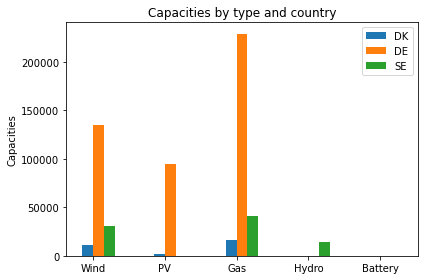

In [155]:
plot_capacities()

## Plot first week in Germany

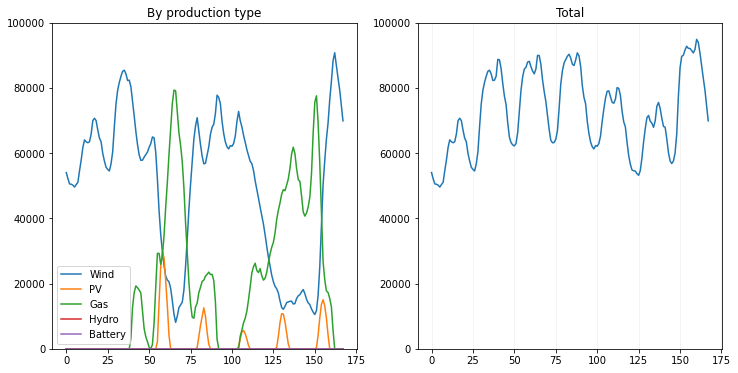

In [156]:
plot_first_week()


# Exercise 2

## Add CO2 constraint

In [157]:
# Total CO generated in cell found previously
co2_limit = 0.1 * total_co2

# Add CO2 limit constraint
model.co2_limit_constraint = Constraint(expr= sum(model.prod[node, "Gas", t] for node in model.nodes for t in model.time) <= co2_limit)

## Solve model again

In [158]:
# results = solve_model()
# results.write()

## Add batteries

In [143]:

model.battery_level = Var(model.nodes,model.time, domain=NonNegativeReals, doc="Battery level by country")


# Producing electricity from hydro must decrease water level
def battery_rule(model,node,time):
    if (time > 0):
        return model.battery_level[node,time] == model.battery_level[node,time-1] - model.prod[node, "Battery", time-1] + sum(model.prod[node,tech,time-1] for tech in model.gens) - model.demand[node,time-1]
    else:
        return model.battery_level[node,time] == model.battery_level[node,time]


model.battery_constraint = Constraint(model.nodes,model.time, rule=battery_rule)

# Battery level must be lower than battery max in each country
def battery_level_rule(model,node,time):
    return model.battery_level[node,time] <= model.capa[node, "Battery"]

model.battery_level_constraint = Constraint(model.nodes, model.time, rule=battery_level_rule)

def battery_start_and_end_rule(model,node):
    return model.battery_level[node,0] >= model.battery_level[node,8759]

# Ending battery level must be same as start
model.battery_end_constraint = Constraint(model.nodes, rule=battery_start_and_end_rule)

KeyError: "Index '8759' is not valid for indexed component 'battery_level'"

## Solve with batteries on

In [ ]:
batteryOn = True
results = solve_model()
results.write()

# Exercise 3